In [44]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from joblib import Parallel, delayed
import shutil
import os

In [45]:
# Load the data from the .npy files (path may need to be changed)
training_data_normal = np.load('training_normal.npy')
testing_data_attack = np.load('testing_attack.npy')
testing_data_normal = np.load('testing_normal.npy')

In [46]:
# Concatenate the testing data and generate labels (1 for attack, 0 for normal)
testing_data = np.concatenate((testing_data_attack, testing_data_normal))
testing_labels = np.concatenate((np.ones(len(testing_data_attack)), np.zeros(len(testing_data_normal))))

In [47]:
# Show the size of the data
print("Training data normal shape: ", training_data_normal.shape)
print("Testing data attack shape: ", testing_data_attack.shape)
print("Testing data normal shape: ", testing_data_normal.shape)
print("Testing data shape: ", testing_data.shape)

Training data normal shape:  (20000, 41)
Testing data attack shape:  (4000, 41)
Testing data normal shape:  (4000, 41)
Testing data shape:  (8000, 41)


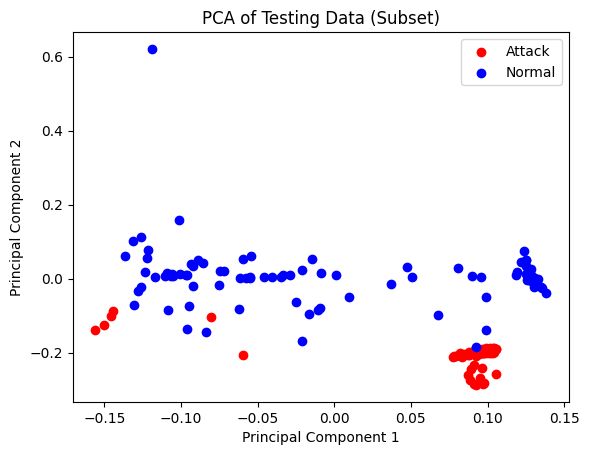

In [48]:
# Visualize subset of testing data
subset_pca = PCA(n_components=2)
subset_pca.fit(training_data_normal)
subset_test_dataset_attack = testing_data_attack[:100]
subset_test_dataset_normal = testing_data_normal[:100]
subset_test_dataset_attack_labels = np.ones(100)
subset_test_dataset_normal_labels = np.zeros(100)
subset_test_dataset_attack_proj = subset_pca.transform(subset_test_dataset_attack)
subset_test_dataset_normal_proj = subset_pca.transform(subset_test_dataset_normal)

# Visualize the data
plt.scatter(subset_test_dataset_attack_proj[:, 0], subset_test_dataset_attack_proj[:, 1], c='r', label='Attack')
plt.scatter(subset_test_dataset_normal_proj[:, 0], subset_test_dataset_normal_proj[:, 1], c='b', label='Normal')
plt.title('PCA of Testing Data (Subset)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [49]:
# Get accuracy, TPR, FPR, and F1 score
def get_performance_metric(predicted_labels, actual_labels):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(predicted_labels)):
        if predicted_labels[i] == 1 and actual_labels[i] == 1:
            TP += 1
        elif predicted_labels[i] == 1 and actual_labels[i] == 0:
            FP += 1
        elif predicted_labels[i] == 0 and actual_labels[i] == 0:
            TN += 1
        elif predicted_labels[i] == 0 and actual_labels[i] == 1:
            FN += 1
    accuracy = (TP + TN) / (TP + FP + TN + FN)
    TPR = TP / (FN + TP)
    FPR = FP / (TN + FP)
    F1 = 2 * TP / (2 * TP + FP + FN)
    return accuracy, TPR, FPR, F1

In [50]:
def init_k_clusters(training_data, k=1):
    # Randomly select k points from the training data as the initial cluster centroids
    cluster_centroids = []
    cluster_indexes = []
    num_clusters_appended = 0
    while num_clusters_appended < k:
        random_index = np.random.randint(0, len(training_data))
        if random_index not in cluster_indexes:
            cluster_centroids.append(training_data[random_index])
            cluster_indexes.append(random_index)
            num_clusters_appended += 1
    return cluster_centroids

In [51]:
def cluster_data(cluster_centroids, data):
    cluster_points = [[] for i in range(len(cluster_centroids))]
    for point in data:
        min_distance = np.linalg.norm(point - cluster_centroids[0])
        closest_cluster = 0
        for i in range(1, len(cluster_centroids)):
            distance = np.linalg.norm(point - cluster_centroids[i])
            if distance < min_distance:
                min_distance = distance
                closest_cluster = i
        cluster_points[closest_cluster].append(point)
    return cluster_points

In [52]:
def cluster_data_classify(cluster_centroids, data, threshold=0.5):
    classify_points = [[], []]
    point_and_prediction = [[], []]
    for point in data:
        min_distance = np.linalg.norm(point - cluster_centroids[0])
        closest_cluster = 0
        for i in range(1, len(cluster_centroids)):
            distance = np.linalg.norm(point - cluster_centroids[i])
            if distance < min_distance:
                min_distance = distance
                closest_cluster = i
        # Apply threshold, put in classify_points[0] if distance is less than threshold, else put in classify_points[1]
        # Index 0 is normal, index 1 is attack
        if min_distance < threshold:
            classify_points[0].append(point)
            point_and_prediction[0].append(point)
            point_and_prediction[1].append(0)
        else:
            classify_points[1].append(point)
            point_and_prediction[0].append(point)
            point_and_prediction[1].append(1)
    return classify_points, point_and_prediction

In [53]:
def k_means(training_data, k=1, max_iterations=100):
    # Initialize the cluster centroids
    cluster_centroids = init_k_clusters(training_data, k)
    # Iterate until convergence (centroids no longer change), or until max_iterations is reached
    for iteration in range(max_iterations):
        # Copy previous cluster centroids for comparison
        previous_cluster_centroids = cluster_centroids.copy()
        # Cluster the data
        cluster_points = cluster_data(cluster_centroids, training_data)
        # Update the cluster centroids
        for i in range(len(cluster_centroids)):
            cluster_centroids[i] = np.mean(cluster_points[i], axis=0)
        # Check for convergence
        if np.array_equal(previous_cluster_centroids, cluster_centroids):
            break
    return cluster_centroids

In [54]:
def run_k_means_classifier(training_data, testing_data, testing_labels, threshold=0.5, k=4, num_dimensions=2, show=False):
    # Use PCA to reduce the dimensionality of the data to the specified number of dimension
    pca = PCA(n_components=num_dimensions)

    # Fit the PCA model to the training data and project the training data onto n principal components
    training_data_normal_projected = pca.fit_transform(training_data)

    # Project the testing data to the same number of dimensions as the training data
    testing_data_projected = pca.transform(testing_data)

    # Perform k-Means clustering on the projected training data
    cluster_centroids = k_means(training_data_normal_projected, k)

    # Print the cluster centroids
    # print("Cluster Centroids:")
    # for i in range(len(cluster_centroids)):
    #     print(f"Cluster {i+1}: {cluster_centroids[i]}")

    # Cluster the testing data using the updated cluster centroids
    predicted_points, point_and_prediction = cluster_data_classify(cluster_centroids, testing_data_projected, threshold)

    # Create subplots to show the clustered data and the testing labels
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    # Create labels for the data points
    labels = ['Normal', 'Attack']
    colors = ['blue', 'red']

    # Plot the predicted data
    for i in range(len(predicted_points)):
        # Skip if there are no points in the cluster
        if len(predicted_points[i]) == 0:
            continue
        # Plot the predicted classifications for testing points
        axs[0].scatter(np.array(predicted_points[i])[:, 0], np.array(predicted_points[i])[:, 1], label=labels[i], color=colors[i])
    
    # Set labels for clustered data plot
    axs[0].set_xlabel('First Principal Component')
    axs[0].set_ylabel('Second Principal Component')
    axs[0].set_title('k-Means Classifier Predictions')
    axs[0].legend()

    # Plot the testing data with the actual labels
    labeled_points = [testing_data_projected[np.where(testing_labels == 0)], testing_data_projected[np.where(testing_labels == 1)]]
    for i in range(2):
        axs[1].scatter(labeled_points[i][:, 0], labeled_points[i][:, 1], label=labels[i], color=colors[i])
    
    # Set labels for testing data plot
    axs[1].set_xlabel('First Principal Component')
    axs[1].set_ylabel('Second Principal Component')
    axs[1].set_title('Labeled Testing Data')
    axs[1].legend()

    # Get performance metrics
    accuracy, TPR, FPR, F1 = get_performance_metric(point_and_prediction[1], testing_labels)
    # print("Accuracy: ", accuracy)
    # print("TPR: ", TPR)
    # print("FPR: ", FPR)
    # print("F1 Score: ", F1)

    # Save the plots in format: k_means_k_<clusters>_t_<threshold>_a_<accuracy>_tpr_<tpr>_fpr_<fpr>_f_<f1score>.png
    # Performance metrics should be rounded to 4 decimal places
    plt.savefig(f"grid_search_k_means/k_means_k_{k}_t_{threshold}_a_{round(accuracy, 4)}_tpr_{round(TPR, 4)}_fpr_{round(FPR, 4)}_f_{round(F1, 4)}.png")

    # Show the plot
    if show:
        plt.show()

    # Close the plot
    plt.close()

    # Return the performance metrics
    return accuracy, TPR, FPR, F1

In [55]:
# Get the neighbors of a point within a certain radius (epsilon)
def region_query(data, point_index, epsilon):
    distances = np.linalg.norm(data - data[point_index], axis=1)
    return np.where(distances <= epsilon)[0]

In [56]:
""" ChatGPT was used to optimize the loops in the original fit function """
def dbscan_fit(training_data, epsilon=0.1, min_pts=4):
    n = len(training_data)
    cluster_labels = np.full(n, -1)                         # -1 means noise, will be updated with cluster numbers
    visited = np.zeros(n, dtype=bool)
    cluster_id = 0

    # Loop through all points in the dataset
    for point_index in range(n):
        if visited[point_index]:
            continue
        
        # Mark the point as visited
        visited[point_index] = True
        neighbors = region_query(training_data, point_index, epsilon)

        # If the point doesn't have enough neighbors, mark it as noise
        if len(neighbors) < min_pts:
            cluster_labels[point_index] = -1                # Noise
            continue
        
        # Start a new cluster
        cluster_labels[point_index] = cluster_id
        queue = set(neighbors.tolist())                     # Using set to avoid duplicate insertions

        # Visit each point in the queue
        while queue:
            # Get the next point from the queue
            neighbor_index = queue.pop()
            # If the point has not been visited yet
            if not visited[neighbor_index]:
                # Mark the point as visited
                visited[neighbor_index] = True
                # Get the neighbors of the point and add them to the queue if there are enough neighbors
                new_neighbors = region_query(training_data, neighbor_index, epsilon)
                if len(new_neighbors) >= min_pts:
                    queue.update(new_neighbors.tolist())

            # Assign the neighbor to the current cluster if it's unclassified
            if cluster_labels[neighbor_index] == -1:
                cluster_labels[neighbor_index] = cluster_id

        # Iterate cluster_id for the next cluster
        cluster_id += 1                                     

    # Return the cluster labels for each point
    return cluster_labels

In [57]:
# Classify the testing data using the DBSCAN model (based on proximity to core points)
def near_core_point(core_points, test_point, epsilon):
    # Return if the test point is within epsilon of a core point
    distances = np.linalg.norm(core_points - test_point, axis=1)
    return np.any(distances <= epsilon)

In [58]:
def run_dbscan(training_data, testing_data, testing_labels, epsilon=0.05, num_neighbors=4, show=False):
    # Use PCA to reduce the dimensionality of the data to the specified number of dimension
    pca = PCA(n_components=2)

    # Fit the PCA model to the training data and project the training data onto n principal components
    training_data_projected = pca.fit_transform(training_data)

    # Project the testing data to the same number of dimensions as the training data
    testing_data_projected = pca.transform(testing_data)

    # Fit DBScan on training data
    cluster_labels = dbscan_fit(training_data_projected, epsilon, num_neighbors)

    # Classify testing points based on core points
    core_points = training_data_projected[cluster_labels != -1]

    # Classify the testing points
    predicted_labels = np.array([0 if near_core_point(core_points, test_point, epsilon) else 1 for test_point in testing_data_projected])

    # Get the performance metrics
    accuracy, TPR, FPR, F1 = get_performance_metric(predicted_labels, testing_labels)

    # Print the performance metrics
    # print("Accuracy: ", accuracy)
    # print("True Positive Rate: ", TPR)
    # print("False Positive Rate: ", FPR)
    # print("F1 Score: ", F1)

    # Create subplots to show the predicted labels and the actual labels
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Create labels for the data points
    labels = ['Normal', 'Attack']
    colors = ['blue', 'red']

    # Plot the testing data with the predicted labels
    predicted_points = [testing_data_projected[np.where(predicted_labels == 0)], testing_data_projected[np.where(predicted_labels == 1)]]
    for i in range(2):
        axs[0].scatter(predicted_points[i][:, 0], predicted_points[i][:, 1], label=labels[i], color=colors[i])

    # Plot the testing data with the actual labels
    actual_points = [testing_data_projected[np.where(testing_labels == 0)], testing_data_projected[np.where(testing_labels == 1)]]
    for i in range(2):
        axs[1].scatter(actual_points[i][:, 0], actual_points[i][:, 1], label=labels[i], color=colors[i])

    # Set the titles and labels for the subplots
    axs[0].set_title('Predicted Labels')
    axs[0].set_xlabel('Principal Component 1')
    axs[0].set_ylabel('Principal Component 2')
    axs[0].legend()

    axs[1].set_title('Actual Labels')
    axs[1].set_xlabel('Principal Component 1')
    axs[1].set_ylabel('Principal Component 2')
    axs[1].legend()

    # Save the plots in format: dbscan_e_<epsilon>_n_<num_neighbors>_a_<accuracy>_tpr_<tpr>_fpr_<fpr>_f_<f1score>.png
    # Performance metrics should be rounded to 4 decimal places
    plt.savefig(f'grid_search_dbscan/dbscan_e_{epsilon}_n_{num_neighbors}_a_{round(accuracy, 4)}_tpr_{round(TPR, 4)}_fpr_{round(FPR, 4)}_f_{round(F1, 4)}.png')

    # Show the plots
    if show:
        plt.show()
    
    # Close the plots
    plt.close()

    # Return the performance metrics
    return accuracy, TPR, FPR, F1

In [59]:
# Evaluate a single k-Means configuration
def evaluate_kmeans(training_data, testing_data, testing_labels, k, t, pca_dim=2):
    """
    Evaluates k-Means clustering for a specific combination of hyperparameters

    Parameters:
    - data: Input data
    - k: Number of clusters
    - t: Distance threshold value 
    - pca_dim: Number of dimensions to reduce to using PCA

    Returns:
    - Dictionary containing the parameters and accuracy score
    """
    
    # Initialize k-Means with specified hyperparameters and obtain the accuracy
    accuracy = run_k_means_classifier(training_data, testing_data, testing_labels, threshold=t, k=k, num_dimensions=pca_dim)

    # Return the parameters and the accuracy
    return {'k': k, 't': t, 'pca_dim': pca_dim, 'score': accuracy}

In [60]:
# Function to tune k-Means hyperparameters in parallel
def tune_kmeans(training_data, testing_data, testing_labels, k_values, t_values):
    """
    Tunes k-Means hyperparameters using parallel processing

    Parameters:
    - data: Input data
    - k_values: List of k values to test
    - t_values: List of threshold values to test
    - pca_dimensions: Number of dimensions to reduce to using PCA

    Returns:
    - Best hyperparameter combination based on accuracy

    AI Usage:
        Chat GPT Prompt:
            Optimize the following code using parallel processing:
            def tune_kmeans(X, k_values, t_values, pca_dimensions):
                best_params = {'k': None, 't': None, 'pca_dim': None, 'score': -1}
                
                for pca_dim in pca_dimensions:
                    X_transformed = X if pca_dim is None else PCA(n_components=pca_dim).fit_transform(X)
                    
                    for k in k_values:
                        for t in t_values:
                            kmeans = KMeans(n_clusters=k, tol=t, random_state=42)
                            labels = kmeans.fit_predict(X_transformed)
                            score = silhouette_score(X_transformed, labels)
                            
                            if score > best_params['score']:
                                best_params = {'k': k, 't': t, 'pca_dim': pca_dim, 'score': score}
                
                return best_params
    """

    # Use parallel processing to evaluate multiple configurations
    results = Parallel(n_jobs=-1)(delayed(evaluate_kmeans)(training_data, testing_data, testing_labels, k, t)
                                  for k in k_values
                                  for t in t_values)
    
    # Return the best configuration
    return max(results, key=lambda x: x['score'], default={'k': None, 't': None, 'pca_dim': None, 'score': -1})

In [61]:
# Evaluate a single DBSCAN configuration
def evaluate_dbscan(data, testing_data, testing_labels, eps, min_samples, pca_dim=2):
    """
    Evaluates DBSCAN clustering for a specific combination of hyperparameters.

    Parameters:
    - data: Input data
    - eps: Epsilon value (radius of neighborhood)
    - min_samples: Minimum number of neighbors to be a core point
    - pca_dim: Number of dimensions to reduce to using PCA

    Returns:
    - Dictionary containing the parameters and accuracy, or None if clustering fails.
    """

    # Init DBSCAN with specified hyperparameters and obtain the accuracy
    accuracy = run_dbscan(data, testing_data, testing_labels, eps, min_samples)

    # Return the parameters and the accuracy
    return {'eps': eps, 'min_samples': min_samples, 'pca_dim': pca_dim, 'score': accuracy}

In [62]:
# Function to tune DBSCAN hyperparameters in parallel
def tune_dbscan(data, testing_data, testing_labels, eps_values, min_samples_values):
    """
    Tunes DBSCAN hyperparameters using parallel processing

    Parameters:
    - data: Input data
    - eps_values: List of epsilon values to test
    - min_samples_values: List of min_samples values to test

    Returns:
    - Best hyperparameter combination based on silhouette score

    AI Usage:
        Chat GPT Prompt:
            Optimize the following code using parallel processing:
            def tune_dbscan(X, eps_values, min_samples_values, pca_dimensions):
                best_params = {'eps': None, 'min_samples': None, 'pca_dim': None, 'score': -1}

                for pca_dim in pca_dimensions:
                    X_transformed = X if pca_dim is None else PCA(n_components=pca_dim).fit_transform(X)
                    
                    for eps in eps_values:
                        for min_samples in min_samples_values:
                            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
                            labels = dbscan.fit_predict(X_transformed)
                            
                            if len(set(labels)) > 1:
                                score = silhouette_score(X_transformed, labels)
                                
                                if score > best_params['score']:
                                    best_params = {'eps': eps, 'min_samples': min_samples, 'pca_dim': pca_dim, 'score': score}
                
                return best_params
    """

    # Use parallel processing to evaluate multiple configurations
    results = Parallel(n_jobs=-1)(delayed(evaluate_dbscan)(data, testing_data, testing_labels, eps, min_samples)
                                  for eps in eps_values
                                  for min_samples in min_samples_values)
    
    # Return the best configuration
    return max(results, key=lambda x: x['score'], default={'eps': None, 'min_samples': None, 'pca_dim': None, 'score': -1})

In [74]:
# Set parameter ranges for hyperparameter tuning
k_values = [2, 4, 6, 8, 10, 12]
threshold_values = [0.01, 0.1, 0.15, 0.2, 0.5]
epsilon_values = [0.001, 0.005, 0.01, 0.05, 0.1]
min_neighbors_values = [2, 4, 6, 8, 10]
# PCA dimensions for k-Means and DBSCAN were hardcoded to 2 for this task
pca_dimensions = [2]

In [64]:
# Delete and recreate the grid_search_k_means directory
shutil.rmtree('grid_search_k_means', ignore_errors=True)
os.makedirs('grid_search_k_means')

# Hyperparameter tuning for k-Means
best_kmeans_params = tune_kmeans(training_data_normal, testing_data, testing_labels, k_values, threshold_values)
print("\n Best k-Means Parameters")
print(f"  - Optimal Clusters (k): {best_kmeans_params['k']}")
print(f"  - Threshold (t): {best_kmeans_params['t']:.6f}")
print(f"  - PCA Dimensions: {best_kmeans_params['pca_dim']}")
print(f"  - Accuracy, TPR, FPR, F1: {best_kmeans_params['score']}")


 Best k-Means Parameters
  - Optimal Clusters (k): 6
  - Threshold (t): 0.100000
  - PCA Dimensions: 2
  - Accuracy, TPR, FPR, F1: (0.957125, 0.95875, 0.0445, 0.957194558841882)


In [75]:
# Delete and recreate the grid_search_dbscan directory
shutil.rmtree('grid_search_dbscan', ignore_errors=True)
os.makedirs('grid_search_dbscan')

# Hyperparameter tuning for DBSCAN
best_dbscan_params = tune_dbscan(training_data_normal, testing_data, testing_labels, epsilon_values, min_neighbors_values)
print("\n Best DBSCAN Parameters")
print(f"  - Epsilon (eps): {best_dbscan_params['eps']}")
print(f"  - Min Samples: {best_dbscan_params['min_samples']}")
print(f"  - PCA Dimensions: {best_dbscan_params['pca_dim']}")
print(f"  - Accuracy, TPR, FPR, F1: {best_dbscan_params['score']}\n")


 Best DBSCAN Parameters
  - Epsilon (eps): 0.005
  - Min Samples: 8
  - PCA Dimensions: 2
  - Accuracy, TPR, FPR, F1: (0.836125, 0.74675, 0.0745, 0.820041180507893)



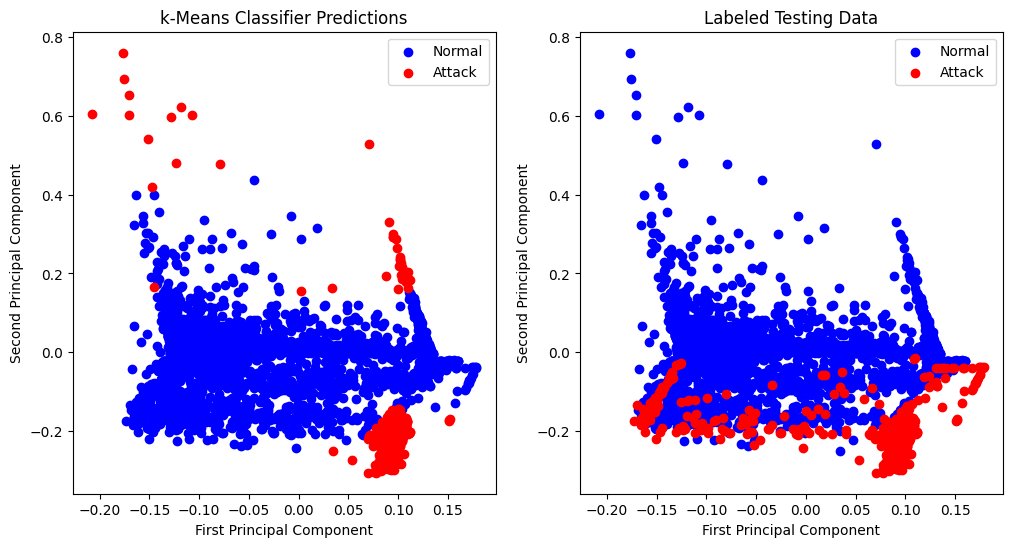

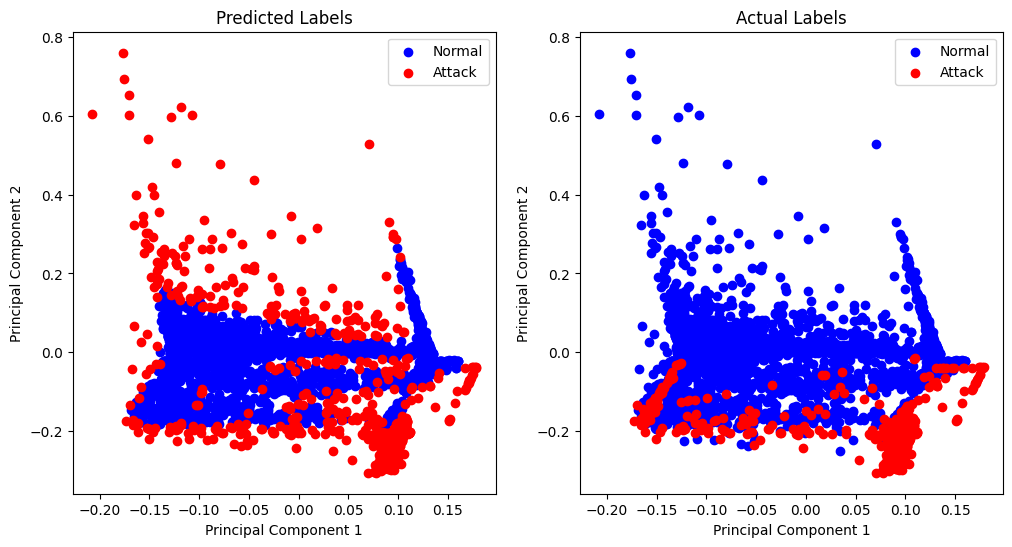

(0.836125, 0.74675, 0.0745, 0.820041180507893)

In [79]:
# Train the best k-Means model
run_k_means_classifier(training_data_normal, testing_data, testing_labels, threshold=0.15, k=4, show=True)

# Train the best DBSCAN model
run_dbscan(training_data_normal, testing_data, testing_labels, epsilon=0.005, num_neighbors=8, show=True)

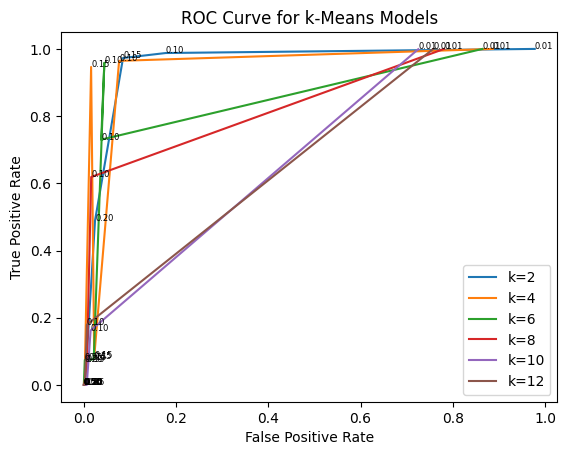

In [80]:
# Read in the names of the files in the grid_search_k_means directory
files = os.listdir('grid_search_k_means')
k_means_files = [file for file in files if file.startswith('k_means')]

# Parse the filenames to extract the accuracy, TPR, FPR, and F1 score
k_means_metrics = []
for file in k_means_files:
    parts = file.split('_')
    num_clusters = float(parts[3])
    threshold = float(parts[5])
    accuracy = float(parts[7])
    TPR = float(parts[9])
    FPR = float(parts[11])
    # Use [:-4] to remove the .png extension
    F1 = float(parts[13][:-4]) 
    k_means_metrics.append((num_clusters, threshold, accuracy, TPR, FPR, F1))

# For all k values, generate an ROC curve using models generated from that k value
# The ROC curve will show the TPR vs FPR for each threshold value
for k in k_values:
    # Get the metrics for the k value
    k_metrics = [metrics for metrics in k_means_metrics if metrics[0] == k]
    # Sort the metrics by threshold value
    k_metrics.sort(key=lambda x: x[1])
    # Get the TPR and FPR values
    TPR_values = [metrics[3] for metrics in k_metrics]
    FPR_values = [metrics[4] for metrics in k_metrics]
    # Plot the ROC curve
    plt.plot(FPR_values, TPR_values, label=f'k={k}')
    # Show the threshold values on the plot
    for i, txt in enumerate(k_metrics):
        plt.annotate(f"{txt[1]:.2f}", (FPR_values[i], TPR_values[i]), fontsize=6)

# Set the labels and title for the ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for k-Means Models')
plt.legend()
plt.show()


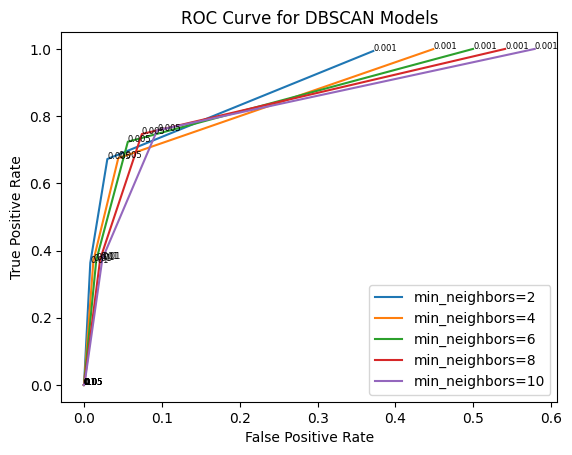

In [81]:
# Read in the names of the files in the grid_search_dbscan directory
files = os.listdir('grid_search_dbscan')
dbscan_files = [file for file in files if file.startswith('dbscan')]

# Parse the filenames to extract the accuracy, TPR, FPR, and F1 score
dbscan_metrics = []
for file in dbscan_files:
    parts = file.split('_')
    epsilon = float(parts[2])
    num_neighbors = float(parts[4])
    accuracy = float(parts[6])
    TPR = float(parts[8])
    FPR = float(parts[10])
    # Use [:-4] to remove the .png extension
    F1 = float(parts[12][:-4]) 
    dbscan_metrics.append((epsilon, num_neighbors, accuracy, TPR, FPR, F1))

# For all min neighbors values, generate an ROC curve using models generated from that min neighbors value
# The ROC curve will show the TPR vs FPR for each epsilon value
for min_neighbors in min_neighbors_values:
    # Get the metrics for the min neighbors value
    min_neighbors_metrics = [metrics for metrics in dbscan_metrics if metrics[1] == min_neighbors]
    # Sort the metrics by epsilon value
    min_neighbors_metrics.sort(key=lambda x: x[0])
    # Get the TPR and FPR values
    TPR_values = [metrics[3] for metrics in min_neighbors_metrics]
    FPR_values = [metrics[4] for metrics in min_neighbors_metrics]
    # Plot the ROC curve
    plt.plot(FPR_values, TPR_values, label=f'min_neighbors={min_neighbors}')
    # Show the threshold values for each point
    for i in range(len(min_neighbors_metrics)):
        plt.text(FPR_values[i], TPR_values[i], f'{min_neighbors_metrics[i][0]}', fontsize=6)

# Set the labels and title for the ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for DBSCAN Models')
plt.legend()
plt.show()